# Import libraries

In [1]:
import os
import getpass
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import csv
import umap
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from itertools import product
from sklearn.neighbors import NearestNeighbors
import re

2024-04-25 21:15:01.775110: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-25 21:15:01.904703: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 21:15:01.904803: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 21:15:01.914790: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-25 21:15:01.962222: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-25 21:15:01.964027: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
def extract_email(arr):
    # Check if the input is a list or array
    if isinstance(arr, list) or isinstance(arr, np.ndarray):
        # Iterate through each element
        for element in arr:
            # Recursively call the function for nested lists or arrays
            email = extract_email(element)
            if email is not None:
                return email
    # If it's a string, check if it's an email address
    elif isinstance(arr, str):
        if re.match(r"[^@]+@[^@]+\.[^@]+", arr):
            return arr
    # Return None if no email address is found
    return None

In [3]:
question_significance = {
    "seating_question_1": "Salt or Paprika?",
    "seating_question_2": "Which starter pokemon would you choose?",
    "seating_question_3": "Which Hogward house are you?",
    "seating_question_4": "Ideal friday evening?",
    "seating_question_5": "What's your favorite drink?",
    "seating_question_6": "What is most likely to exist?",
    "seating_question_7": "What is the best aroma?",
    "seating_question_8": "What where we talking about?",
    "seating_question_9": "What is your favoured language?",
    "seating_question_10": "Who do you prefer?",
}

weigths = {
    "seating_question_1": 0.5,
    "seating_question_2": 1,
    "seating_question_3": 2,
    "seating_question_4": 2,
    "seating_question_5": 6,
    "seating_question_6": 6,
    "seating_question_7": 4,
    "seating_question_8": 3,
    "seating_question_9": 5,
    "seating_question_10": 1,
}

In [4]:
# Function to update values
def update_values(value_counts):
    def update(x):
        count = value_counts.get(x)
        if count:
            return f"{x}-{count}"
        else:
            return x
    return update

In [6]:

server = "ec2-54-72-196-9.eu-west-1.compute.amazonaws.com"
db = "d2fect8juldk3k"
user = "puybkltrealynp"
pswd = getpass.getpass(prompt="Enter password: ")
pswd_to_enter = "10aefdea5dcd6a4366ab1e0f46cbf91366144b7a3ad7252478db2c63357fec4e"
# Set the PGPASSWORD environment variable
os.environ['PGPASSWORD'] = pswd

# Execute the PostgreSQL command without specifying the password
os.system(f"psql -h {server} -U {user} -d {db} -c 'SELECT name, email, name, family_name, has_answered_form, answer_diner, plusones, seating_question_1, seating_question_2, seating_question_3, seating_question_4, seating_question_5, seating_question_6, seating_question_7, seating_question_8, seating_question_9, seating_question_10, seating_question_11, seating_question_12, seating_question_13, seating_question_14, seating_question_15 FROM users;' -o seatings.csv")


Enter password:  ········


0

# Load complete database

In [7]:
full_csv = pd.read_csv(f"seatings.csv", delimiter="|")
# Strip leading and trailing spaces from every element in the DataFrame
full_csv = full_csv.applymap(lambda x: x.strip() if isinstance(x, str) else x)
full_csv.columns = full_csv.columns.str.strip()
full_csv = full_csv.dropna()

/tmp/ipykernel_122077/2183413473.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  full_csv = full_csv.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [8]:
full_csv['email'] = full_csv['email'].str.lower()
full_csv['email'] = full_csv['email'].str.rstrip('.')
full_csv.to_csv(f"seating_cleaned.csv")
full_csv

,name,email,name .1,family_name,has_answered_form,answer_diner,plusones,seating_question_1,seating_question_2,seating_question_3,...,seating_question_6,seating_question_7,seating_question_8,seating_question_9,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15
1,Pierre,pietdel@gmail.com,Pierre,Delacroix,yes,yes,,01_paprika,02_charmander,03_gryffondor,...,06_aliens,07_pepper,08_spices,09_france,10_love_math,,,,,
2,Alexis,alexis@adbproduction.com,Alexis,,yes,no,,01_paprika,02_bulbasaur,03_slitherin,...,06_nessie,07_chocolate,08_sex,09_france,10_love_math,,,,,
3,Caroline,carolinewvh@gmail.com,Caroline,Wesselman van Helmond,yes,yes,leonore.vehmeijer@gmail.com,01_paprika,02_squirtle,03_huffelpuf,...,06_ghost,07_chocolate,08_icecream,09_unitedkingdom,10_love_math,,,,,
4,Erica,erica.efst@gmail.com,Erica,Efstratoudakis,yes,yes,aamoratis@gmail.com,01_salt,02_squirtle,03_gryffondor,...,06_aliens,07_chocolate,08_icecream,09_unitedkingdom,10_love_liv,,,,,
5,Charles-Henri,ch.starckmann@gmail.com,Charles-Henri,Starckmann,yes,yes,,01_paprika,02_squirtle,03_gryffondor,...,06_nessie,07_chocolate,08_icecream,09_france,10_love_liv,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,Reny <3,lukitoreny@hotmail.com,Reny <3,,no,no,,,,,...,,,,,,,,,,
205,Dara,khosrowshahidara@gmail.com,Dara,Khosrowshahi,yes,yes,,01_paprika,02_squirtle,03_huffelpuf,...,06_ghost,07_pepper,08_sex,09_france,10_love_math,,,,,
206,BigNickkk,bignick@blasband.com,BigNickkk,Blasband,yes,yes,,,,,...,,,,,,,,,,
207,Alicia,alice.athanassiadis@gmail.com,Alicia,,yes,yes,Alexis Philippart de Foy,01_paprika,02_charmander,03_slitherin,...,06_aliens,07_chocolate,08_icecream,09_france,10_love_math,,,,,


# People who answered but answered no (to double check)

In [9]:
check = full_csv[full_csv["has_answered_form"] == "yes"]
check = check[check["answer_diner"] == "no"]
check

,name,email,name .1,family_name,has_answered_form,answer_diner,plusones,seating_question_1,seating_question_2,seating_question_3,...,seating_question_6,seating_question_7,seating_question_8,seating_question_9,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15
2,Alexis,alexis@adbproduction.com,Alexis,,yes,no,,01_paprika,02_bulbasaur,03_slitherin,...,06_nessie,07_chocolate,08_sex,09_france,10_love_math,,,,,
21,Clarinette,cldursel@gmail.com,Clarinette,d'Ursel,yes,no,,,,,...,,,,,,,,,,
31,Amelie,ami@dg.com,Amelie,,yes,no,Livia,01_paprika,02_bulbasaur,03_slitherin,...,06_nessie,07_pepper,08_sex,09_france,10_love_math,,,,,
39,Isaure,isauredv@gmail.com,Isaure,,yes,no,,,,,...,,,,,,,,,,
42,Olivier,odeguerre@free.fr,Olivier,,yes,no,,01_paprika,02_squirtle,03_huffelpuf,...,06_nessie,07_chocolate,08_icecream,09_france,10_love_liv,,,,,
48,Sarah,sarah.cresap.johnson@gmail.com,Sarah,Clemm,yes,no,,01_salt,02_charmander,03_ravenclaw,...,06_nessie,07_pistachio,08_icecream,09_unitedkingdom,10_love_liv,,,,,
66,Tony,adenicolay@gmail.com,Tony,de Nicolay,yes,no,,01_paprika,02_bulbasaur,03_gryffondor,...,06_god,07_vanilla,08_sex,09_france,10_love_math,,,,,
84,Laurent,laurent.michiels@bain.com,Laurent,Michiels,yes,no,Louise Snoy,,,,...,,,,,,,,,,
89,Aad,adriaanvanberckel2009@hotmail.com,Aad,,yes,no,,01_salt,02_charmander,03_gryffondor,...,06_god,07_pistachio,08_sex,,,,,,,
149,Joyce,joycevn1@gmail.com,Joyce,Van Nieuwerburgh,yes,no,,,,,...,,,,,,,,,,


# Double check the plusones to include them

In [10]:
where_plus_ones = full_csv[full_csv["plusones"].str.strip() != ""][['name','email','plusones']]
where_plus_ones['plusones'] = where_plus_ones['plusones'].str.rstrip('.')
temp = pd.DataFrame()
temp['email'] = list(where_plus_ones['plusones'])
temp['who_invites_them'] = list(where_plus_ones['email'])
# Assuming df1 and df2 are your DataFrames
merged_df = pd.merge(temp, full_csv[['email','name']],on='email', how='left')
merged_df
# Filter out rows with NaN values in the columns from df2
excluded_rows = merged_df[merged_df['name'].isnull()]
excluded_rows

,email,who_invites_them,name
4,Gijs,cathelijnevanderwouden@gmail.com,NaN
9,Livia,ami@dg.com,NaN
10,Duco van Lanschot,zarahabeln@live.nl,NaN
11,Xenia Popowski,alexsvo@me.com,NaN
21,Louise Snoy,laurent.michiels@bain.com,NaN
23,Cathelijne van der Wouden,gj.oudewesselink@gmail.com,NaN
24,Alexandra Schultz,alexander.schwennicke@gmail.com,NaN
25,Maurice van Manen,ylmsiemer@gmail.com,NaN
29,Marie Osterrieth,arnaud.decleve0807@gmail.com,NaN
33,Thomas,valeriedeguerre@gmail.com,NaN


# Load additional information

In [11]:
additional = pd.read_csv(f"important_info.csv", delimiter=",",header=0)
additional['email'] = additional['email'].str.lower()
additional['email'] = additional['email'].str.rstrip('.')
additional

,email,Sex,friend_of,table
0,victor.stinglhamber@gmail.com,male,10_mat,1.0
1,bertichat@gmail.com,male,10_mat,1.0
2,fdelimburg@gmail.com,male,10_mat,1.0
3,jdursel@gmail.com,male,10_mat,1.0
4,harold.loop@gmail.com,male,10_mat,1.0
...,...,...,...,...
219,dehemptinneb@gmail.com,male,10_parents,NaN
220,ami@dg.com,female,10_mat,NaN
221,chdelachapelle@gmail.com,male,10_parents,NaN
222,margueritesvo@me.com,female,10_parents,NaN


In [12]:
merged_total = pd.merge(full_csv, additional[['email','Sex', 'friend_of']], on='email', how='inner')

duplicated_indices = [6]
while len(duplicated_indices) > 0:
    try:
        duplicated_indices = merged_total[merged_total.duplicated(subset=['email'], keep=False)].index
        index_to_drop = np.random.choice(duplicated_indices)
        merged_total = merged_total.drop(index_to_drop)
    except Exception as e:
        print(e)

'a' cannot be empty unless no samples are taken


In [13]:
merged_total

,name,email,name .1,family_name,has_answered_form,answer_diner,plusones,seating_question_1,seating_question_2,seating_question_3,...,seating_question_8,seating_question_9,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15,Sex,friend_of
0,Pierre,pietdel@gmail.com,Pierre,Delacroix,yes,yes,,01_paprika,02_charmander,03_gryffondor,...,08_spices,09_france,10_love_math,,,,,,male,10_mat
1,Caroline,carolinewvh@gmail.com,Caroline,Wesselman van Helmond,yes,yes,leonore.vehmeijer@gmail.com,01_paprika,02_squirtle,03_huffelpuf,...,08_icecream,09_unitedkingdom,10_love_math,,,,,,female,10_mat
2,Erica,erica.efst@gmail.com,Erica,Efstratoudakis,yes,yes,aamoratis@gmail.com,01_salt,02_squirtle,03_gryffondor,...,08_icecream,09_unitedkingdom,10_love_liv,,,,,,female,10_liv
3,Charles-Henri,ch.starckmann@gmail.com,Charles-Henri,Starckmann,yes,yes,,01_paprika,02_squirtle,03_gryffondor,...,08_icecream,09_france,10_love_liv,,,,,,male,10_mat
4,Darren,darrenmk1@gmail.com,Darren,Kripaitis,yes,yes,,,,,...,,,,,,,,,male,10_mat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,Reny <3,lukitoreny@hotmail.com,Reny <3,,no,no,,,,,...,,,,,,,,,female,10_mat
202,Dara,khosrowshahidara@gmail.com,Dara,Khosrowshahi,yes,yes,,01_paprika,02_squirtle,03_huffelpuf,...,08_sex,09_france,10_love_math,,,,,,male,10_mat
203,BigNickkk,bignick@blasband.com,BigNickkk,Blasband,yes,yes,,,,,...,,,,,,,,,male,10_mat
204,Alicia,alice.athanassiadis@gmail.com,Alicia,,yes,yes,Alexis Philippart de Foy,01_paprika,02_charmander,03_slitherin,...,08_icecream,09_france,10_love_math,,,,,,female,10_mat


# People from who we dont have information

In [14]:
merged_df = pd.merge(full_csv[['email','name']], additional[['email']], on='email', how='outer', suffixes=('_df1', '_df2'))
# Convert lists to sets
set1 = set(list(full_csv['email']))
set2 = set(list(additional['email']))

# Find elements not shared by both sets
elements_not_shared = set1.symmetric_difference(set2)
elements_not_shared

{'alexis.philippartdefoy@gmail.com',
 'alexis.phillipartdefoy@gmail.com',
 'alexis@adbproduction.com',
 'bernhard.clemm@mail.de',
 'dehemptinneb@gmail.com',
 'denicolaytatiana@gmail.com',
 'e.debeauffort@gmail.com',
 'elenaderibaucourt@gmail.com',
 'karthikrao00@gmail.com',
 'laureline.maheo@yahoo.fr',
 'louisdebrouwer@hotmail.com',
 'ludmilladepotter@gmail.com',
 'oliviadt90@gmail.com',
 'pdormesson@gmail.com',
 'plusone_phillipe',
 'sindhurasonnathi@gmail.com',
 'stijn.riviere@gmail.com',
 'tanine.daryoush@gmail.com',
 'tom.cartuyvels@hotmail.com',
 'toutia.daryoush@gmail.com'}

In [15]:
emails_list = list(elements_not_shared)
# Specify the CSV file path
csv_file_path = "not_shared.csv"

# Write list to CSV file
with open(csv_file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['email'])  # Write header
    writer.writerows([[email] for email in emails_list])

# People who answered the form but didnt do the table seating game

In [16]:
answered_invitation_but_didnt_play = full_csv[full_csv['has_answered_form'] == 'yes']
answered_invitation_but_didnt_play = answered_invitation_but_didnt_play[answered_invitation_but_didnt_play["seating_question_1"].str.strip() == ""]
answered_invitation_but_didnt_play

,name,email,name .1,family_name,has_answered_form,answer_diner,plusones,seating_question_1,seating_question_2,seating_question_3,...,seating_question_6,seating_question_7,seating_question_8,seating_question_9,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15
6,Darren,darrenmk1@gmail.com,Darren,Kripaitis,yes,yes,,,,,...,,,,,,,,,,
11,Mams,azinedeh@gmail.com,Mams,de Hemptinne,yes,yes,,,,,...,,,,,,,,,,
21,Clarinette,cldursel@gmail.com,Clarinette,d'Ursel,yes,no,,,,,...,,,,,,,,,,
39,Isaure,isauredv@gmail.com,Isaure,,yes,no,,,,,...,,,,,,,,,,
65,Sunshine,alexr89@hotmail.fr,Sunshine,Renie,yes,yes,,,,,...,,,,,,,,,,
84,Laurent,laurent.michiels@bain.com,Laurent,Michiels,yes,no,Louise Snoy,,,,...,,,,,,,,,,
98,Gizz,gj.oudewesselink@gmail.com,Gizz,,yes,yes,Cathelijne van der Wouden,,,,...,,,,,,,,,,
100,Julian (Jules),j.siegelmann@me.com,Julian (Jules),Siegelmann,yes,yes,,,,,...,,,,,,,,,,
102,Robert,vdlindenrj@gmail.com,Robert,van der Linden,yes,yes,,,,,...,,,,,,,,,,
108,Anne Katharina,a.k.greul@gmail.com,Anne Katharina,Greul,yes,yes,,,,,...,,,,,,,,,,


# All people who at least started the table seating game

In [17]:
only_answered = merged_total[merged_total["seating_question_1"].str.strip() != ""]
only_answered

,name,email,name .1,family_name,has_answered_form,answer_diner,plusones,seating_question_1,seating_question_2,seating_question_3,...,seating_question_8,seating_question_9,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15,Sex,friend_of
0,Pierre,pietdel@gmail.com,Pierre,Delacroix,yes,yes,,01_paprika,02_charmander,03_gryffondor,...,08_spices,09_france,10_love_math,,,,,,male,10_mat
1,Caroline,carolinewvh@gmail.com,Caroline,Wesselman van Helmond,yes,yes,leonore.vehmeijer@gmail.com,01_paprika,02_squirtle,03_huffelpuf,...,08_icecream,09_unitedkingdom,10_love_math,,,,,,female,10_mat
2,Erica,erica.efst@gmail.com,Erica,Efstratoudakis,yes,yes,aamoratis@gmail.com,01_salt,02_squirtle,03_gryffondor,...,08_icecream,09_unitedkingdom,10_love_liv,,,,,,female,10_liv
3,Charles-Henri,ch.starckmann@gmail.com,Charles-Henri,Starckmann,yes,yes,,01_paprika,02_squirtle,03_gryffondor,...,08_icecream,09_france,10_love_liv,,,,,,male,10_mat
6,Chachaa,vandenbulcke.cha@gmail.com,Chachaa,Van den Bulcke,yes,yes,,01_paprika,02_charmander,03_ravenclaw,...,08_icecream,09_france,10_love_liv,,,,,,female,10_liv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,Eugénie,eugenie_stinglhamber@hotmail.com,Eugénie,Stinglhamber,yes,yes,,01_salt,02_bulbasaur,03_huffelpuf,...,08_sex,09_france,10_love_liv,,,,,,female,10_mat
199,Victor,victor.stinglhamber@gmail.com,Victor,Stinglhamber,yes,yes,,01_paprika,02_charmander,03_slitherin,...,08_spices,09_france,10_love_liv,,,,,,male,10_mat
200,Maaaaaaccc,bergmansmartin2@hotmail.com,Maaaaaaccc,Berg(sansH)mans,yes,yes,ysalinedonner@gmail.com,01_paprika,02_charmander,03_gryffondor,...,08_icecream,09_france,10_love_liv,,,,,,male,10_mat
202,Dara,khosrowshahidara@gmail.com,Dara,Khosrowshahi,yes,yes,,01_paprika,02_squirtle,03_huffelpuf,...,08_sex,09_france,10_love_math,,,,,,male,10_mat


# Weird group who played but answered no for dinner

In [18]:
weird_group = only_answered[only_answered["answer_diner"] == "no"]
weird_group

,name,email,name .1,family_name,has_answered_form,answer_diner,plusones,seating_question_1,seating_question_2,seating_question_3,...,seating_question_8,seating_question_9,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15,Sex,friend_of
28,Amelie,ami@dg.com,Amelie,,yes,no,Livia,01_paprika,02_bulbasaur,03_slitherin,...,08_sex,09_france,10_love_math,,,,,,female,10_mat
38,Olivier,odeguerre@free.fr,Olivier,,yes,no,,01_paprika,02_squirtle,03_huffelpuf,...,08_icecream,09_france,10_love_liv,,,,,,male,10_parents
44,Sarah,sarah.cresap.johnson@gmail.com,Sarah,Clemm,yes,no,,01_salt,02_charmander,03_ravenclaw,...,08_icecream,09_unitedkingdom,10_love_liv,,,,,,female,10_liv
62,Tony,adenicolay@gmail.com,Tony,de Nicolay,yes,no,,01_paprika,02_bulbasaur,03_gryffondor,...,08_sex,09_france,10_love_math,,,,,,male,10_mat
85,Aad,adriaanvanberckel2009@hotmail.com,Aad,,yes,no,,01_salt,02_charmander,03_gryffondor,...,08_sex,,,,,,,,male,10_liv
155,Gaspar,gdursel@gmail.com,Gaspar,d'Ursel,yes,no,,01_salt,02_charmander,03_gryffondor,...,08_spices,09_unitedkingdom,10_love_liv,,,,,,male,10_mat
161,Papili,thdeguerre@gmail.com,Papili,de Guerre,yes,no,anastasiadeguerre@gmail.com,01_salt,02_bulbasaur,03_gryffondor,...,08_sex,09_france,10_love_liv,,,,,,male,10_parents


In [19]:
len(only_answered)

141

# Filtering out parents

In [20]:
only_answered = only_answered[only_answered["friend_of"]!="10_parents"]

# Filtering out those who said no to the diner

In [21]:
only_answered = only_answered[only_answered["answer_diner"]!="no"]

# Double checking one last time plusones

In [22]:
where_plus_ones = only_answered[only_answered["plusones"].str.strip() != ""][['name','email','plusones']]
where_plus_ones['plusones'] = where_plus_ones['plusones'].str.rstrip('.')
temp = pd.DataFrame()
temp['email'] = list(where_plus_ones['plusones'])
temp['who_invites_them'] = list(where_plus_ones['email'])
# Assuming df1 and df2 are your DataFrames
merged_df = pd.merge(temp, only_answered[['email','name']],on='email', how='left')
merged_df
# Filter out rows with NaN values in the columns from df2
excluded_rows = merged_df[merged_df['name'].isnull()]
excluded_rows

,email,who_invites_them,name
2,philipvb@outlook.com,mpwesterwoudt@gmail.com,NaN
4,Gijs,cathelijnevanderwouden@gmail.com,NaN
9,Duco van Lanschot,zarahabeln@live.nl,NaN
10,Xenia Popowski,alexsvo@me.com,NaN
13,guillain-cornet@hotmail.com,avanvolsem@hotmail.com,NaN
19,laureline.maheo@yahoo.fr,charko.doultremont@gmail.com,NaN
21,Alexandra Schultz,alexander.schwennicke@gmail.com,NaN
22,Maurice van Manen,ylmsiemer@gmail.com,NaN
26,Marie Osterrieth,arnaud.decleve0807@gmail.com,NaN
27,rafdegroot@gmail.com,rendtz@gmail.com,NaN


# Only seating questions to encode

In [23]:
only_seating_colls = only_answered[["friend_of","seating_question_1","seating_question_2","seating_question_3","seating_question_4","seating_question_5","seating_question_6","seating_question_7","seating_question_8","seating_question_9","seating_question_10"]]
only_seating_colls = only_seating_colls.applymap(lambda x: str(x).split('_')[-1])
only_seating_colls.replace(r'^\s*$', "no answer", regex=True, inplace=True)
only_seating_colls

/tmp/ipykernel_122077/3761749874.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  only_seating_colls = only_seating_colls.applymap(lambda x: str(x).split('_')[-1])


,friend_of,seating_question_1,seating_question_2,seating_question_3,seating_question_4,seating_question_5,seating_question_6,seating_question_7,seating_question_8,seating_question_9,seating_question_10
0,mat,paprika,charmander,gryffondor,browncafe,wine,aliens,pepper,spices,france,math
1,mat,paprika,squirtle,huffelpuf,clubbing,tea,ghost,chocolate,icecream,unitedkingdom,math
2,liv,salt,squirtle,gryffondor,browncafe,wine,aliens,chocolate,icecream,unitedkingdom,liv
3,mat,paprika,squirtle,gryffondor,browncafe,beer,nessie,chocolate,icecream,france,liv
6,liv,paprika,charmander,ravenclaw,browncafe,coffee,nessie,chocolate,icecream,france,liv
...,...,...,...,...,...,...,...,...,...,...,...
198,mat,salt,bulbasaur,huffelpuf,browncafe,beer,aliens,pistachio,sex,france,liv
199,mat,paprika,charmander,slitherin,browncafe,wine,aliens,chocolate,spices,france,liv
200,mat,paprika,charmander,gryffondor,browncafe,gin,aliens,chocolate,icecream,france,liv
202,mat,paprika,squirtle,huffelpuf,browncafe,beer,ghost,pepper,sex,france,math


In [24]:
mask = (only_seating_colls == "no answer").any(axis=1)
temp = only_answered[['name','email']]
temp = pd.concat([temp, only_seating_colls], axis = 1)
not_finished_answering = temp[mask]
not_finished_answering

,name,email,friend_of,seating_question_1,seating_question_2,seating_question_3,seating_question_4,seating_question_5,seating_question_6,seating_question_7,seating_question_8,seating_question_9,seating_question_10


In [25]:
filtered_df = only_seating_colls[~mask]
needed_later = only_answered
needed_later = needed_later[~mask]
filtered_df

,friend_of,seating_question_1,seating_question_2,seating_question_3,seating_question_4,seating_question_5,seating_question_6,seating_question_7,seating_question_8,seating_question_9,seating_question_10
0,mat,paprika,charmander,gryffondor,browncafe,wine,aliens,pepper,spices,france,math
1,mat,paprika,squirtle,huffelpuf,clubbing,tea,ghost,chocolate,icecream,unitedkingdom,math
2,liv,salt,squirtle,gryffondor,browncafe,wine,aliens,chocolate,icecream,unitedkingdom,liv
3,mat,paprika,squirtle,gryffondor,browncafe,beer,nessie,chocolate,icecream,france,liv
6,liv,paprika,charmander,ravenclaw,browncafe,coffee,nessie,chocolate,icecream,france,liv
...,...,...,...,...,...,...,...,...,...,...,...
198,mat,salt,bulbasaur,huffelpuf,browncafe,beer,aliens,pistachio,sex,france,liv
199,mat,paprika,charmander,slitherin,browncafe,wine,aliens,chocolate,spices,france,liv
200,mat,paprika,charmander,gryffondor,browncafe,gin,aliens,chocolate,icecream,france,liv
202,mat,paprika,squirtle,huffelpuf,browncafe,beer,ghost,pepper,sex,france,math


In [26]:
# Initialize OneHotEncoder
encoder = OneHotEncoder()
# Fit and transform the data
encoded_data = encoder.fit_transform(filtered_df)

In [67]:
one_hot_encoded = pd.DataFrame(encoded_data.toarray(), columns = encoder.get_feature_names_out())

In [68]:
one_hot_encoded

,friend_of_liv,friend_of_mat,seating_question_1_paprika,seating_question_1_salt,seating_question_2_bulbasaur,seating_question_2_charmander,seating_question_2_squirtle,seating_question_3_gryffondor,seating_question_3_huffelpuf,seating_question_3_ravenclaw,...,seating_question_8_icecream,seating_question_8_sex,seating_question_8_spices,seating_question_9_belgium,seating_question_9_france,seating_question_9_germany,seating_question_9_netherlands,seating_question_9_unitedkingdom,seating_question_10_liv,seating_question_10_math
0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
118,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
119,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
120,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


# Weight the different questions differently

In [69]:
nr_features = {
    "friend_of": 3,
    "seating_question_1": 2,
    "seating_question_2": 3,
    "seating_question_3": 4,
    "seating_question_4": 3,
    "seating_question_5": 6,
    "seating_question_6": 5,
    "seating_question_7": 4,
    "seating_question_8": 3,
    "seating_question_9": 5,
    "seating_question_10": 2,
}

question_significance = {
    "friend_of": "Who is inviting them?",
    "seating_question_1": "Salt or Paprika?",
    "seating_question_2": "Which starter pokemon would you choose?",
    "seating_question_3": "Which Hogward house are you?",
    "seating_question_4": "Ideal friday evening?",
    "seating_question_5": "What's your favorite drink?",
    "seating_question_6": "What is most likely to exist?",
    "seating_question_7": "What is the best aroma?",
    "seating_question_8": "What where we talking about?",
    "seating_question_9": "What is your favoured language?",
    "seating_question_10": "Who do you prefer?",
}


weigths = {
    "friend_of": 0,
    "seating_question_1": 0.4,
    "seating_question_2": 1.2,
    "seating_question_3": 0.9,
    "seating_question_4": 0.7,
    "seating_question_5": 0.6,
    "seating_question_6": 0.8,
    "seating_question_7": 0.5,
    "seating_question_8": 0.5,
    "seating_question_9": 0.5,
    "seating_question_10": 0.5,
}

In [70]:
scaler = StandardScaler()
scaler.fit(one_hot_encoded)
normalized_data = scaler.transform(one_hot_encoded)
one_hot_encoded = pd.DataFrame(normalized_data, columns=one_hot_encoded.columns)
temp = list(one_hot_encoded.columns)
modified_array = [word[:word.rindex('_')] for word in temp]
to_multi_1 = []
to_multi_2 = []
for word in modified_array:
    to_multi_1.append(weigths[word])
    to_multi_2.append(nr_features[word])
# Multiply each column with its corresponding float
for i, col in enumerate(one_hot_encoded.columns):
    one_hot_encoded[col] = one_hot_encoded[col] * to_multi_1[i]
    one_hot_encoded[col] = one_hot_encoded[col] * to_multi_2[i]
one_hot_encoded

,friend_of_liv,friend_of_mat,seating_question_1_paprika,seating_question_1_salt,seating_question_2_bulbasaur,seating_question_2_charmander,seating_question_2_squirtle,seating_question_3_gryffondor,seating_question_3_huffelpuf,seating_question_3_ravenclaw,...,seating_question_8_icecream,seating_question_8_sex,seating_question_8_spices,seating_question_9_belgium,seating_question_9_france,seating_question_9_germany,seating_question_9_netherlands,seating_question_9_unitedkingdom,seating_question_10_liv,seating_question_10_math
0,-0.0,0.0,0.736906,-0.736906,-2.010296,3.781625,-2.283373,4.176859,-1.735197,-1.546182,...,-1.5,-0.856560,2.569988,-0.227273,2.900597,-0.705541,-1.005935,-1.844424,-1.331438,1.331438
1,-0.0,0.0,0.736906,-0.736906,-2.010296,-3.427098,5.675813,-3.102810,7.468892,-1.546182,...,1.5,-0.856560,-0.875490,-0.227273,-2.154729,-0.705541,-1.005935,3.388592,-1.331438,1.331438
2,0.0,-0.0,-0.868496,0.868496,-2.010296,-3.427098,5.675813,4.176859,-1.735197,-1.546182,...,1.5,-0.856560,-0.875490,-0.227273,-2.154729,-0.705541,-1.005935,3.388592,0.751068,-0.751068
3,-0.0,0.0,0.736906,-0.736906,-2.010296,-3.427098,5.675813,4.176859,-1.735197,-1.546182,...,1.5,-0.856560,-0.875490,-0.227273,2.900597,-0.705541,-1.005935,-1.844424,0.751068,-0.751068
4,0.0,-0.0,0.736906,-0.736906,-2.010296,3.781625,-2.283373,-3.102810,-1.735197,8.381935,...,1.5,-0.856560,-0.875490,-0.227273,2.900597,-0.705541,-1.005935,-1.844424,0.751068,-0.751068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,-0.0,0.0,-0.868496,0.868496,6.446812,-3.427098,-2.283373,-3.102810,7.468892,-1.546182,...,-1.5,2.626785,-0.875490,-0.227273,2.900597,-0.705541,-1.005935,-1.844424,0.751068,-0.751068
118,-0.0,0.0,0.736906,-0.736906,-2.010296,3.781625,-2.283373,-3.102810,-1.735197,-1.546182,...,-1.5,-0.856560,2.569988,-0.227273,2.900597,-0.705541,-1.005935,-1.844424,0.751068,-0.751068
119,-0.0,0.0,0.736906,-0.736906,-2.010296,3.781625,-2.283373,4.176859,-1.735197,-1.546182,...,1.5,-0.856560,-0.875490,-0.227273,2.900597,-0.705541,-1.005935,-1.844424,0.751068,-0.751068
120,-0.0,0.0,0.736906,-0.736906,-2.010296,-3.427098,5.675813,-3.102810,7.468892,-1.546182,...,-1.5,2.626785,-0.875490,-0.227273,2.900597,-0.705541,-1.005935,-1.844424,-1.331438,1.331438


# Run PCA

In [71]:
nr_lower_dims = 10
lower_dims_labels = [f"dim{i}" for i in range(1, nr_lower_dims + 1)]

In [72]:
pca = PCA(n_components=nr_lower_dims)

# Fit the PCA model to your one-hot encoded DataFrame
pca.fit(one_hot_encoded)

# Transform the data to its principal components
pca_result = pca.transform(one_hot_encoded)

# Create a new DataFrame to store the principal components
pca_df = pd.DataFrame(data=pca_result, columns=lower_dims_labels)

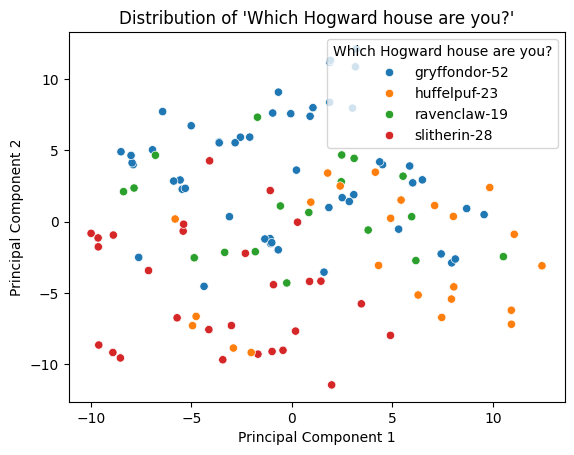

In [73]:
current_question = "seating_question_3"
signify = question_significance[current_question]
pca_df[signify] = list(filtered_df[current_question])
value_counts = pca_df[signify].value_counts()
pca_df[signify] = pca_df[signify].apply(update_values(value_counts))
# Create a scatter plot using Seaborn
sns.scatterplot(x='dim1', y='dim2', data=pca_df, hue = signify)
plt.title(f"Distribution of '{signify}'")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Run UMAP

In [74]:
# Run UMAP
reducer = umap.UMAP(n_components=nr_lower_dims)
embedding = reducer.fit_transform(one_hot_encoded)

In [75]:
# Create a new DataFrame to store the principal components
umap_df = pd.DataFrame(data=embedding, columns=lower_dims_labels)

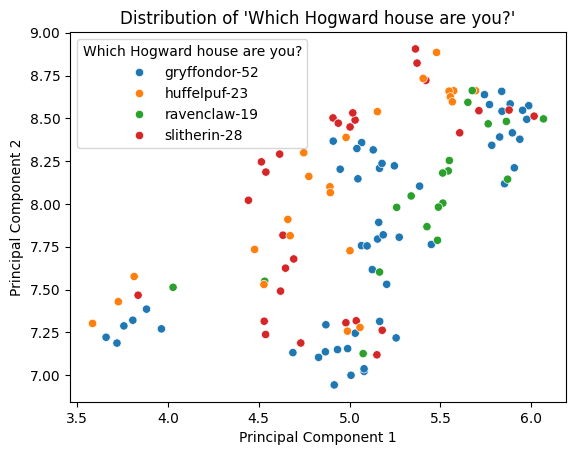

In [76]:
current_question = "seating_question_3"
signify = question_significance[current_question]
umap_df[signify] = list(filtered_df[current_question])
value_counts = umap_df[signify].value_counts()
umap_df[signify] = umap_df[signify].apply(update_values(value_counts))
# Create a scatter plot using Seaborn
sns.scatterplot(x='dim1', y='dim2', data=umap_df, hue = signify)
plt.title(f"Distribution of '{signify}'")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Cluster pairs

In [84]:
nr_lower_dim = 10 # based on how many dims you calculate the distance
lower_dims_labels = [f"dim{i}" for i in range(1, nr_lower_dims + 1)]

In [85]:
#chosen_dim = umap_df[lower_dims_labels] # choose umap or PCA (or others)
chosen_dim = pca_df[lower_dims_labels] # choose umap or PCA (or others)
chosen_dim['gender'] = list(needed_later['Sex'])
chosen_dim['email'] = list(needed_later['email'])

In [86]:
gender_counts = chosen_dim['gender'].value_counts()
if gender_counts.female >= gender_counts.male:
    most_present = "female"
else:
    most_present = "male"

In [87]:
gender_counts.female

67

In [88]:
gender_counts.male

55

In [89]:
most_present

'female'

In [90]:
table_names_and_sizes = {
    "goldstrike":[32],
    "tequila":[14],
    "jagermeister":[14],
    "liquer43":[14],
    "salmari":[12],
    "limoncello":[12],
    "cointreau":[10],
    "peardrop":[9],
    "curacao":[12],
    "genepi":[10],
}

nr_of_tables = len(table_names_and_sizes)

In [91]:
if most_present == 'female':
    least_present = 'male'
    starting_df = chosen_dim[chosen_dim['gender']=='male'][lower_dims_labels+['email']]
    overschot = chosen_dim[chosen_dim['gender']=='female'][lower_dims_labels+['email']]
else:
    least_present = 'female'
    overschot = chosen_dim[chosen_dim['gender']=='male'][lower_dims_labels+['email']]
    starting_df = chosen_dim[chosen_dim['gender']=='female'][lower_dims_labels+['email']]

In [92]:
extraction = one_hot_encoded
extraction['email'] = list(needed_later['email'])
extraction['name'] = list(needed_later['name'])
extraction['family_name'] = list(needed_later['family_name'])
columns = extraction.columns.tolist()
new_columns = columns[-3:] + columns[:-3]
extraction = extraction[new_columns]

matching_pairs_one_hot = []
matching_pairs_emails = []

nn = NearestNeighbors(n_neighbors=1, algorithm='auto')
while len(starting_df) > 0:
    df1 = starting_df.head(1)
    df2 = overschot
    # Convert pandas DataFrames to numpy arrays
    df1_array = df1[lower_dims_labels].to_numpy()
    df2_array = df2[lower_dims_labels].to_numpy()
    df2_to_read = df2.to_numpy()

    # Flatten the arrays to 2D
    df1_flat = df1_array.reshape(len(df1_array), -1)
    df2_flat = df2_array.reshape(len(df2_array), -1)
    df2_to_read_flat = df2_to_read.reshape(len(df2_to_read), -1)

    nn.fit(df2_flat)
    distances, indices = nn.kneighbors(df1_flat)

    email_overschot = extract_email(df2_to_read_flat[indices])
    email_init = list(df1.email)[0]

    starting_df = starting_df[starting_df['email'] != email_init]
    overschot = overschot[overschot['email'] != email_overschot]

    couple = extraction[(extraction['email'] == email_overschot) | (extraction['email'] == email_init)]
    couple_additional_info = chosen_dim[(chosen_dim['email'] == email_overschot) | (chosen_dim['email'] == email_init)]
    merged_df = pd.merge(couple_additional_info, couple, on='email')
    columns = merged_df.columns.tolist()
    new_columns = merged_df.columns[3:6].tolist() + [col for col in columns if col not in merged_df.columns[3:6]]
    couple = merged_df[new_columns]

    matching_pairs_one_hot.append(couple)
    matching_pairs_emails.append([email_init,email_overschot])

In [93]:
matching_pairs_emails_df = pd.DataFrame(matching_pairs_emails, columns = [f"email {least_present}",f"email {most_present}"])
matching_pairs_emails_df

,email male,email female
0,pietdel@gmail.com,poli.camilla@gmail.com
1,ch.starckmann@gmail.com,annesophievv@hotmail.com
2,harold.delacroix@gmail.com,annadansembourg@gmail.com
3,jdursel@gmail.com,mvlvputbus@gmail.com
4,stevenvriesendorp@hotmail.com,l.h.devries@outlook.com
5,deloozphil@gmail.com,priscilla.dudhia@gmail.com
6,amvaneden@gmail.com,iphigeniedesellier@gmail.com
7,matthieu.dehemptinne@gmail.com,liviadeguerre@gmail.com
8,aamoratis@gmail.com,resitherwood@gmail.com
9,diego.vdp24@hotmail.com,catalina.de.schrevel@hotmail.com


# Re-run for overschot

In [94]:
if most_present == 'female':
    least_present = 'male'
    starting_df = overschot
    overschot = chosen_dim[chosen_dim['gender']=='male'][lower_dims_labels+['email']]
else:
    least_present = 'female'
    starting_df = overschot
    overschot = chosen_dim[chosen_dim['gender']=='female'][lower_dims_labels+['email']]

In [95]:
matching_pairs_overschot_one_hot = []
matching_pairs_overschot_emails = []
while len(starting_df) > 0:
    df1 = starting_df.head(1)
    df2 = overschot
    # Convert pandas DataFrames to numpy arrays
    df1_array = df1[lower_dims_labels].to_numpy()
    df2_array = df2[lower_dims_labels].to_numpy()
    df2_to_read = df2.to_numpy()

    # Flatten the arrays to 2D
    df1_flat = df1_array.reshape(len(df1_array), -1)
    df2_flat = df2_array.reshape(len(df2_array), -1)
    df2_to_read_flat = df2_to_read.reshape(len(df2_to_read), -1)

    nn.fit(df2_flat)
    distances, indices = nn.kneighbors(df1_flat)

    email_overschot = extract_email(df2_to_read_flat[indices])
    email_init = list(df1.email)[0]

    starting_df = starting_df[starting_df['email'] != email_init]
    overschot = overschot[overschot['email'] != email_overschot]

    couple = extraction[(extraction['email'] == email_overschot) | (extraction['email'] == email_init)]
    couple_additional_info = chosen_dim[(chosen_dim['email'] == email_overschot) | (chosen_dim['email'] == email_init)]
    merged_df = pd.merge(couple_additional_info, couple, on='email')
    columns = merged_df.columns.tolist()
    new_columns = merged_df.columns[3:6].tolist() + [col for col in columns if col not in merged_df.columns[3:6]]
    couple = merged_df[new_columns]

    matching_pairs_overschot_one_hot.append(couple)
    matching_pairs_overschot_emails.append([email_init,email_overschot])

In [96]:
matching_pairs_overschot_emails_df = pd.DataFrame(matching_pairs_overschot_emails, columns = [f"email {most_present} overschot",f"email {least_present}"])
matching_pairs_overschot_emails_df

,email female overschot,email male
0,cathelijnevanderwouden@gmail.com,edzard.knyphausen@gmail.com
1,theresaisabelkruse@gmail.com,matthijsdekempenaer@gmail.com
2,freedom-22@hotmail.co.uk,amvaneden@gmail.com
3,kientzelceline@gmail.com,adefoestraets@gmail.com
4,clausscamille@hotmail.com,maurice.vanmanen@hotmail.com
5,ohman.molly@gmail.com,fdelimburg@gmail.com
6,constancevanberckel@gmail.com,jdursel@gmail.com
7,sophiewynaendts@gmail.com,harold.delacroix@gmail.com
8,svanberckel@hotmail.com,thomasdeguerre@gmail.com
9,jiuliadansembourg@gmail.com,leopold.gerard@gmail.com


In [93]:
# Define the cluster sizes
cluster_sizes = [12, 15, 32, 6, 21]

# Initialize KMeans with the desired number of clusters
kmeans = KMeans(n_clusters=len(cluster_sizes))

# Fit KMeans to the UMAP-transformed data
clusters = kmeans.fit_predict(embedding)

# Assign each data point to a cluster
cluster_assignments = []
start = 0
for size in cluster_sizes:
    end = start + size
    cluster_assignments.append(clusters[start:end])
    start = end


/home/mat2m10/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [94]:
# Extract cluster labels
cluster_labels = kmeans.labels_
cluster_labels

array([2, 1, 2, 4, 1, 1, 4, 1, 0, 4, 3, 3, 1, 0, 4, 1, 0, 1, 4, 2, 2, 3,
       0, 1, 0, 3, 1, 1, 0, 4, 4, 4, 0, 2, 3, 2, 0, 4, 4, 4, 1, 4, 3, 1,
       0, 2, 4, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 3, 2, 4, 2, 3, 3, 2, 3, 0,
       2, 4, 1, 4, 3, 3, 2, 0, 4, 2, 4, 2, 4, 2, 2, 1, 2, 2, 0, 4, 3, 2,
       2, 1, 4, 0, 4, 1, 0, 2, 2, 2, 1, 2], dtype=int32)

In [95]:
umap_df['tabels'] = cluster_labels

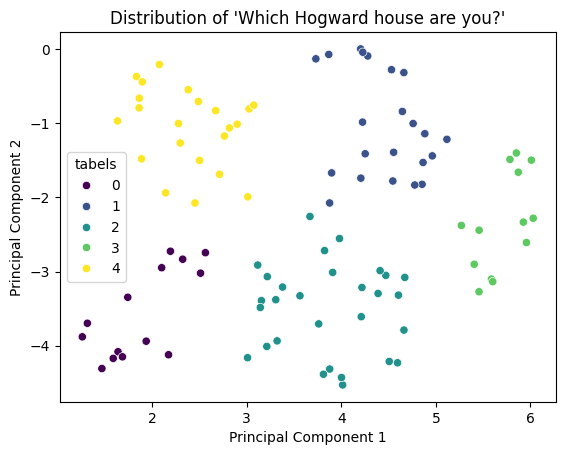

In [96]:
sns.scatterplot(x='dim1', y='dim2', data=umap_df, hue = 'tabels',palette = 'viridis')
plt.title(f"Distribution of '{signify}'")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Groups of males and females

In [99]:
umap_df = umap_df[['dim1','dim2','tabels']]
umap_df['gender'] = list(needed_later['Sex'])
umap_df['email'] = list(needed_later['email'])

In [100]:
# Assuming umap_df is your DataFrame with columns 'dim1', 'dim2', and 'gender'
male_df = umap_df[umap_df['gender'] == 'male']
female_df = umap_df[umap_df['gender'] == 'female']

# Compute pairwise distances between male and female samples
distances = cdist(male_df[['dim1', 'dim2']], female_df[['dim1', 'dim2']])

# Find the closest male-female pairs
min_indices = distances.argmin(axis=1)
closest_pairs = [(male_df.iloc[i], female_df.iloc[j]) for i, j in enumerate(min_indices)]

# Create a DataFrame with the closest pairs
closest_pairs_df = pd.DataFrame(closest_pairs, columns=['Male', 'Female'])


In [148]:
pair = closest_pairs_df.iloc[0]
male = pair['Male']
female = pair['Female']
match = pd.concat([pd.DataFrame(data=male),pd.DataFrame(data=female)],axis=1)
first_db = needed_later[['email','name','family_name']]
first_merge = pd.merge(first_db, match.T[['dim1','dim2','email']], on='email', how='inner')
values_array = [value for value in question_significance.values()]
third_db = needed_later[["friend_of","seating_question_1","seating_question_2","seating_question_3","seating_question_4","seating_question_5","seating_question_6","seating_question_7","seating_question_8","seating_question_9","seating_question_10"]]
# Create a dictionary mapping old column names to new column names
column_mapping = dict(zip(third_db.columns, values_array))

# Rename columns using the dictionary
third_db.rename(columns=column_mapping, inplace=True)
third_db = third_db.applymap(lambda x: str(x).split('_')[-1])
third_db.replace(r'^\s*$', "no answer", regex=True, inplace=True)
third_db['email'] = list(needed_later['email'])
last_merge = pd.merge(first_merge, third_db, on='email', how='inner')
last_merge

/tmp/ipykernel_34378/4076693006.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  third_db.rename(columns=column_mapping, inplace=True)
/tmp/ipykernel_34378/4076693006.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  third_db = third_db.applymap(lambda x: str(x).split('_')[-1])


,email,name,family_name,dim1,dim2,Who is inviting them?,Salt or Paprika?,Which starter pokemon would you choose?,Which Hogward house are you?,Ideal friday evening?,What's your favorite drink?,What is most likely to exist?,What is the best aroma?,What where we talking about?,What is your favoured language?,Who do you prefer?
0,pietdel@gmail.com,Pierre,Delacroix,3.562992,-3.326744,mat,paprika,charmander,gryffondor,browncafe,wine,aliens,pepper,spices,france,math
1,poli.camilla@gmail.com,Camilla,Poli,3.379089,-3.209302,mat,salt,charmander,gryffondor,browncafe,wine,aliens,chocolate,spices,unitedkingdom,math
